In [59]:
import environments
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
dirname = 'cfp-dataset'

In [4]:
root_path = os.path.join(environments.DATASET_DIR, dirname)
img_root = os.path.join(root_path, 'Data/Images')

In [12]:
df_pair_f = pd.read_csv(os.path.join(root_path, 'Protocol', 'Pair_list_F.txt'), sep=' ', header=None)
df_pair_p = pd.read_csv(os.path.join(root_path, 'Protocol', 'Pair_list_P.txt'), sep=' ', header=None)

In [13]:
df_pair_f.head()

,0,1
0,1,../Data/Images/001/frontal/01.jpg
1,2,../Data/Images/001/frontal/02.jpg
2,3,../Data/Images/001/frontal/03.jpg
3,4,../Data/Images/001/frontal/04.jpg
4,5,../Data/Images/001/frontal/05.jpg


## データセットについて

このデータセットは正面からの画像 F と横から取られた画像 P とにわかれている. 

同一性のラベルも FF (正面同士の画像の比較) と FP (正面と横からの画像の比較) に分かれている．テスト精度の計算も FF/FP で別々に算出するようにする

はじめに顔の正規化をする

In [43]:
from face_detection import MtcnnDetector
from src.polish_dataset import clip_most_humanise_image, NotDetectionError
import cv2

In [25]:
img_paths = list(df_pair_f[1]) + list(df_pair_p[1])
img_fullpaths = [os.path.join(root_path, p[3:]) for p in img_paths]

In [28]:
detector = MtcnnDetector(minsize=50)

model folder: /workdir/face_detection/trained_model


Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [30]:
align_img_path = os.path.join(root_path, 'aligned_images')
os.makedirs(align_img_path, exist_ok=True)

In [52]:
results = []

In [54]:
for p in tqdm(img_fullpaths, total=len(img_fullpaths)):
    rel = os.path.relpath(p, img_root)
    clipped_path = os.path.join(align_img_path, rel)
    os.makedirs(os.path.dirname(clipped_path), exist_ok=True)
    img = cv2.imread(p)
    
    detected = False
    try:
        clipped_img, _ = clip_most_humanise_image(detector, img, target_size=environments.INPUT_SHAPE[1], padding_ratio=.3)
        detected = True
    except NotDetectionError:
        print(f'Not Detected... {rel}')
        clipped_img = img
    cv2.imwrite(clipped_path, clipped_img)
    
    results.append([clipped_path, detected])

Not Detected... 011/frontal/09.jpg
Not Detected... 025/frontal/06.jpg
Not Detected... 028/frontal/10.jpg
Not Detected... 032/frontal/02.jpg
Not Detected... 053/frontal/02.jpg
Not Detected... 080/frontal/08.jpg
Not Detected... 107/frontal/08.jpg
Not Detected... 117/frontal/06.jpg
Not Detected... 150/frontal/07.jpg
Not Detected... 156/frontal/03.jpg
Not Detected... 162/frontal/06.jpg
Not Detected... 213/frontal/01.jpg
Not Detected... 230/frontal/07.jpg
Not Detected... 234/frontal/04.jpg
Not Detected... 237/frontal/09.jpg
Not Detected... 254/frontal/01.jpg
Not Detected... 254/frontal/04.jpg
Not Detected... 272/frontal/06.jpg
Not Detected... 272/frontal/08.jpg
Not Detected... 282/frontal/06.jpg
Not Detected... 303/frontal/06.jpg
Not Detected... 308/frontal/07.jpg
Not Detected... 315/frontal/02.jpg
Not Detected... 315/frontal/07.jpg
Not Detected... 339/frontal/10.jpg
Not Detected... 404/frontal/06.jpg
Not Detected... 445/frontal/09.jpg
Not Detected... 457/frontal/07.jpg
Not Detected... 457/

In [65]:
df_meta = pd.DataFrame(results, columns=['img_path', 'detected'])

In [66]:
df_meta['origin_path'] = img_paths
df_meta['detected'] = np.where(df_meta['detected'], 1, 0)
df_meta['img_path'] = [os.path.relpath(p, root_path) for p in df_meta['img_path']]

In [67]:
df_meta.head()

,img_path,detected,origin_path
0,aligned_images/001/frontal/01.jpg,1,../Data/Images/001/frontal/01.jpg
1,aligned_images/001/frontal/02.jpg,1,../Data/Images/001/frontal/02.jpg
2,aligned_images/001/frontal/03.jpg,1,../Data/Images/001/frontal/03.jpg
3,aligned_images/001/frontal/04.jpg,1,../Data/Images/001/frontal/04.jpg
4,aligned_images/001/frontal/05.jpg,1,../Data/Images/001/frontal/05.jpg


In [68]:
df_meta.to_csv(os.path.join(root_path, 'meta.csv'), index=False)

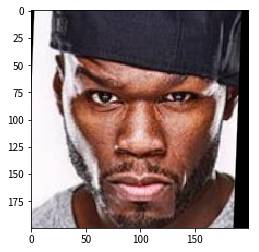

In [49]:
plt.imshow(clipped_img[:, :, ::-1])

## ラベルを CVS にマージ

ディレクトリごとにわかれていると使いにくいのでひとつの csv にマージする

In [69]:
from glob import glob

In [107]:
f2path = dict(df_pair_f.values)
p2path = dict(df_pair_p.values)

path2clipped = dict(df_meta[['origin_path', 'img_path']].values)

In [ ]:
txt_paths = glob(os.path.join(root_path, 'Protocol', 'Split/FF/*/*.txt'))

df_all = None

for p in txt_paths:
    df_i = pd.read_csv(p, header=None)
    n_cv = int(p.split('/')[-2])
    df_i['cv'] = n_cv
    df_i['label'] = int(os.path.basename(p).split('.')[0] == 'same') 
    if df_all is not None:
        df_all = pd.concat([df_all, df_i], ignore_index=True)
    else:
        df_all = df_i

df_all[0] = df_all[0].map(f2path).map(path2clipped)
df_all[1] = df_all[1].map(f2path).map(path2clipped)

df_all.to_csv(os.path.join(root_path, 'ff_meta.csv'), index=False)

In [ ]:
df_all.head()

In [128]:
txt_paths = glob(os.path.join(root_path, 'Protocol', 'Split/FP/*/*.txt'))

df_all = None

for p in txt_paths:
    df_i = pd.read_csv(p, header=None)
    n_cv = int(p.split('/')[-2])
    df_i['cv'] = n_cv
    df_i['label'] = int(os.path.basename(p).split('.')[0] == 'same')
    if df_all is not None:
        df_all = pd.concat([df_all, df_i], ignore_index=True)
    else:
        df_all = df_i

df_all[0] = df_all[0].map(f2path).map(path2clipped)
df_all[1] = df_all[1].map(p2path).map(path2clipped)

df_all.to_csv(os.path.join(root_path, 'fp_meta.csv'), index=False)

In [129]:
df_all.head()

,0,1,cv,label
0,aligned_images/001/frontal/05.jpg,aligned_images/025/profile/01.jpg,1,0
1,aligned_images/001/frontal/03.jpg,aligned_images/024/profile/02.jpg,1,0
2,aligned_images/001/frontal/02.jpg,aligned_images/044/profile/04.jpg,1,0
3,aligned_images/001/frontal/08.jpg,aligned_images/033/profile/02.jpg,1,0
4,aligned_images/001/frontal/07.jpg,aligned_images/002/profile/03.jpg,1,0


## Test

ちゃんとラベルがつけられているかを確認

In [142]:
def show_right_left_images(df):
    fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(6, 3 * 10))

    for i, (_, row) in enumerate(df.iterrows()):
        ax = axes[i]

        img_left = cv2.imread(os.path.join(root_path, row[0]))
        ax[0].imshow(img_left[:, :, ::-1])
        img_right = cv2.imread(os.path.join(root_path, row[1]))
        ax[1].imshow(img_right[:, :, ::-1])
    return fig, axes

おんなじラベル

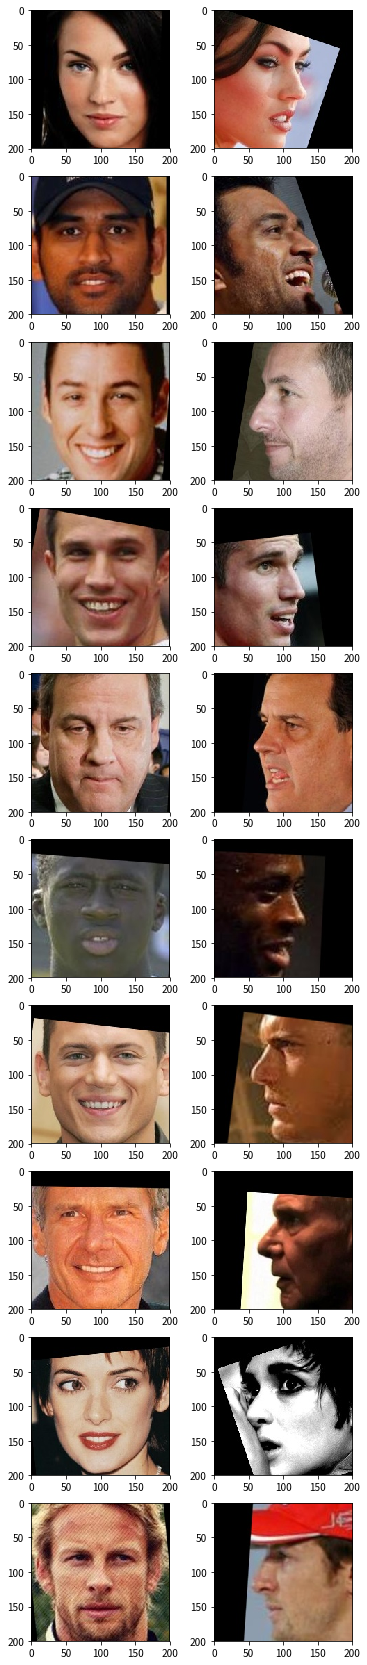

In [144]:
df = df_all[df_all['label'] == 1].sample(10)
_ = show_right_left_images(df)

違うラベル

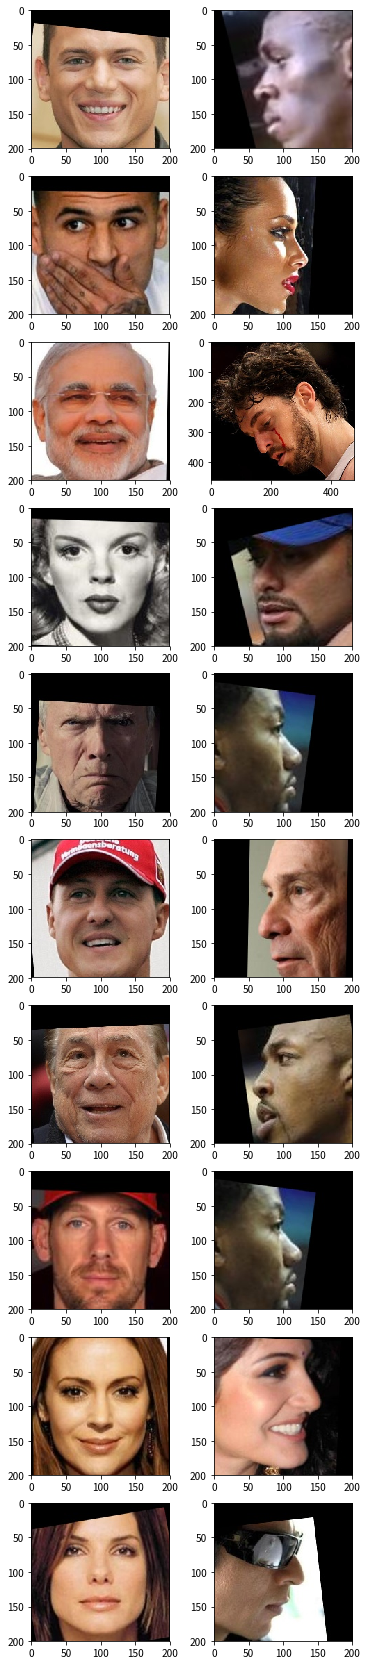

In [145]:
df = df_all[df_all['label'] == 0].sample(10)
_ = show_right_left_images(df)